In [293]:
# Importing Liabraries
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import json

In [294]:
# Reading a Test image
img = cv2.imread("test_images/1 (16).jpeg")
img.shape

(1332, 1175, 3)

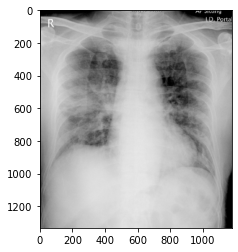

In [295]:
# Plotting a Test image
plt.imshow(img)

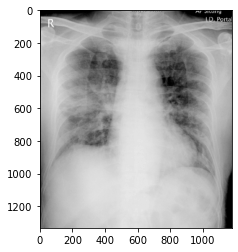

In [296]:
# Plotting the Test image as GrayScale image instead of a RBG image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape
plt.imshow(gray, cmap = "gray")

In [297]:
covid_cascade = cv2.CascadeClassifier("opencv/haarcascades/covid-x-ray.xml")
#left_lung_cascade = cv2.CascadeClassifier("opencv/haarcascades/left_lung_haar.xml")
#right_lung_cascade = cv2.CascadeClassifier("opencv/haarcascades/haarcascade_upperbody.xml")

#left_lung = left_lung_cascade.detectMultiScale(gray, 1.3, 5)
xray = covid_cascade.detectMultiScale(gray, 1.3, 5)

#left_lung
xray

array([[149, 114, 945, 945]], dtype=int32)

In [298]:
(x,y,w,h) = xray[0]
x,y,w,h

(149, 114, 945, 945)

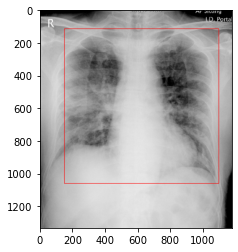

In [299]:
chest_img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
plt.imshow(chest_img)

<function matplotlib.pyplot.show(*args, **kw)>

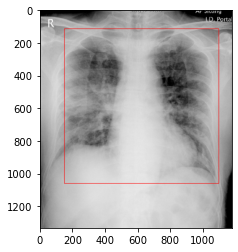

In [300]:
cv2.destroyAllWindows()
for (x,y,w,h) in xray:
    chest_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = chest_img[y:y+h, x:x+w]
    #xray = covid_cascade.detectMultiScale(roi_gray)
  #  for (ex,ey,ew,eh) in xray:
   #     cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
plt.figure()
plt.imshow(chest_img, cmap = "gray")
plt.show

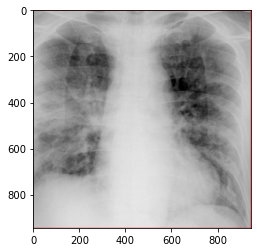

In [301]:
%matplotlib inline
plt.imshow(roi_color, cmap = "gray")

In [314]:
def get_cropped_image_if_1_chest(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    xray = covid_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in xray:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        return roi_color

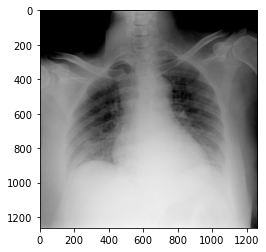

In [315]:
original_image = cv2.imread("test_images/1 (7).jpeg")
plt.imshow(original_image)

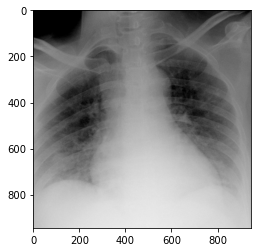

In [316]:
cropped_image = get_cropped_image_if_1_chest("test_images/1 (7).jpeg")
plt.imshow(cropped_image)

In [320]:
path_to_data = "dataset/"
path_to_crop_data = "dataset/cropped/"

In [321]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [322]:
img_dirs

['dataset/covid', 'dataset/normal']

In [323]:
import shutil
if os.path.exists(path_to_crop_data):
    shutil.rmtree(path_to_crop_data)
os.mkdir(path_to_crop_data)

In [324]:
cropped_image_dirs = []
ceo_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    ceo_name = img_dir.split('dataset/')[-1]    
    ceo_file_names_dict[ceo_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_1_chest(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_crop_data + ceo_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            
            cropped_file_name = ceo_name + str(count) + ".jpeg"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            ceo_file_names_dict[ceo_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  dataset/cropped/covid
Generating cropped images in folder:  dataset/cropped/normal


In [325]:
ceo_file_names_dict = {}
for img_dir in cropped_image_dirs:
    ceo_name = img_dir.split('dataset/cropped/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    ceo_file_names_dict[ceo_name] = file_list
ceo_file_names_dict

{'covid': ['dataset/cropped/covid\\covid1.jpeg',
  'dataset/cropped/covid\\covid10.jpeg',
  'dataset/cropped/covid\\covid11.jpeg',
  'dataset/cropped/covid\\covid2.jpeg',
  'dataset/cropped/covid\\covid3.jpeg',
  'dataset/cropped/covid\\covid4.jpeg',
  'dataset/cropped/covid\\covid5.jpeg',
  'dataset/cropped/covid\\covid6.jpeg',
  'dataset/cropped/covid\\covid7.jpeg',
  'dataset/cropped/covid\\covid8.jpeg',
  'dataset/cropped/covid\\covid9.jpeg'],
 'normal': ['dataset/cropped/normal\\normal1.jpeg',
  'dataset/cropped/normal\\normal10.jpeg',
  'dataset/cropped/normal\\normal11.jpeg',
  'dataset/cropped/normal\\normal2.jpeg',
  'dataset/cropped/normal\\normal3.jpeg',
  'dataset/cropped/normal\\normal4.jpeg',
  'dataset/cropped/normal\\normal5.jpeg',
  'dataset/cropped/normal\\normal6.jpeg',
  'dataset/cropped/normal\\normal7.jpeg',
  'dataset/cropped/normal\\normal8.jpeg',
  'dataset/cropped/normal\\normal9.jpeg']}

In [326]:
# Wevelet Transformation

In [327]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

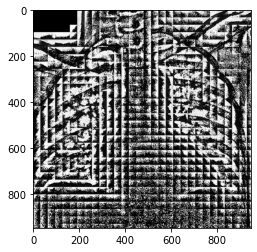

In [328]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [329]:
ceo_file_names_dict

{'covid': ['dataset/cropped/covid\\covid1.jpeg',
  'dataset/cropped/covid\\covid10.jpeg',
  'dataset/cropped/covid\\covid11.jpeg',
  'dataset/cropped/covid\\covid2.jpeg',
  'dataset/cropped/covid\\covid3.jpeg',
  'dataset/cropped/covid\\covid4.jpeg',
  'dataset/cropped/covid\\covid5.jpeg',
  'dataset/cropped/covid\\covid6.jpeg',
  'dataset/cropped/covid\\covid7.jpeg',
  'dataset/cropped/covid\\covid8.jpeg',
  'dataset/cropped/covid\\covid9.jpeg'],
 'normal': ['dataset/cropped/normal\\normal1.jpeg',
  'dataset/cropped/normal\\normal10.jpeg',
  'dataset/cropped/normal\\normal11.jpeg',
  'dataset/cropped/normal\\normal2.jpeg',
  'dataset/cropped/normal\\normal3.jpeg',
  'dataset/cropped/normal\\normal4.jpeg',
  'dataset/cropped/normal\\normal5.jpeg',
  'dataset/cropped/normal\\normal6.jpeg',
  'dataset/cropped/normal\\normal7.jpeg',
  'dataset/cropped/normal\\normal8.jpeg',
  'dataset/cropped/normal\\normal9.jpeg']}

In [330]:
class_dict = {}
count = 0
for ceo_name in ceo_file_names_dict.keys():
    class_dict[ceo_name] = count
    count = count + 1
class_dict

{'covid': 0, 'normal': 1}

In [331]:
X, y = [], []
for ceo_name, training_files in ceo_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[ceo_name])

In [332]:
len(X)

22

In [333]:
len(y)

22

In [334]:
len(X[0])

4096

In [335]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(22, 4096)

In [336]:
X[0]

array([128., 124., 123., ..., 249., 248.,   5.])

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 0)
pipe = Pipeline([("scaler", StandardScaler()),("svc", SVC(kernel = "rbf", C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

1.0

In [338]:
print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         6



In [339]:
model_params = {
    'svm': {
        'model': svm.SVC(probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='ovr'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [340]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.9375,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.9375,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,1.0000,{'logisticregression__C': 10}


In [341]:
best_estimators

{'svm': Pipeline(memory=None,
      steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False))]), 'random_forest': Pipeline(memory=None,
      steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min...n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))]), 'logistic_regression': Pipeline(memory=None,
      steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, 

In [342]:
best_estimators['svm'].score(X_test,y_test)

1.0

In [343]:
best_estimators['random_forest'].score(X_test,y_test)

1.0

In [344]:
best_estimators['logistic_regression'].score(X_test,y_test)

1.0

In [346]:
best_clf = best_estimators['svm']

In [347]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[2, 0],
       [0, 4]], dtype=int64)

Text(69.0, 0.5, 'Truth')

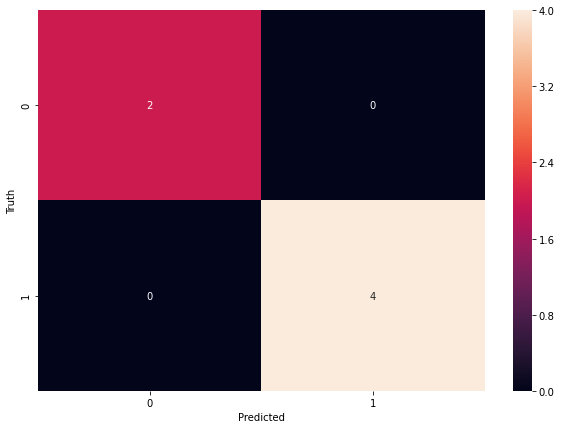

In [348]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [349]:
class_dict

{'covid': 0, 'normal': 1}

In [350]:
# Save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [351]:
# Saving Class Dictionary
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))